# Cleaned vs Dirty V2



Bu projede kullanılan veriler [buradan](https://www.kaggle.com/c/platesv2/data) temin edilmiştir.

In [1]:
import cv2
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [41]:
img_path="plates/train/"
labels = ['cleaned', 'dirty']

In [3]:
def set_df(dir):
    img_list=[]
    label_list=[]
    for label in labels:
        i=0
        for img_file in os.listdir(dir+label):
            i+=1
            img_list.append(dir+label+"/"+img_file)
            label_list.append(label)
    df=pd.DataFrame({"img":img_list, "label":label_list})
    return df

In [4]:
df=set_df(img_path)

In [5]:
d={"dirty":1, "cleaned":0}
df["encode_label"]= df["label"].map(d)

In [6]:
df.sample(10)

,img,label,encode_label
42,plates/train/dirty/0712 - Kopya.jpg,dirty,1
104,plates/train/cleaned/0720.jpg,cleaned,0
53,plates/train/dirty/0734 - Kopya.jpg,dirty,1
0,plates/train/dirty/0000.jpg,dirty,1
17,plates/train/dirty/0017.jpg,dirty,1
62,plates/train/cleaned/0004.jpg,cleaned,0
64,plates/train/cleaned/0006.jpg,cleaned,0
105,plates/train/cleaned/0722.jpg,cleaned,0
58,plates/train/cleaned/0000.jpg,cleaned,0
113,plates/train/cleaned/0741.jpg,cleaned,0


In [7]:
# Veri setini biraz karıştıralım
df=df.sample(frac=1).reset_index(drop=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   img           115 non-null    object
 1   label         115 non-null    object
 2   encode_label  115 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ KB


In [9]:
df["label"].value_counts()

label
dirty      58
cleaned    57
Name: count, dtype: int64

In [10]:
image=cv2.imread(str(df["img"][10]))
image.shape

(256, 342, 3)

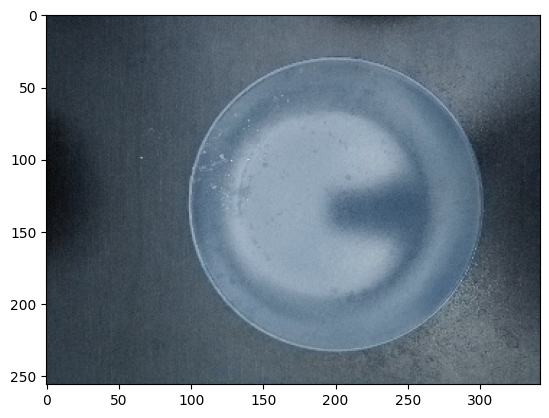

In [11]:
plt.imshow(image)

In [12]:
size=128
x=[]
for image in df["img"]:
    try:
        img=cv2.imread(str(image))
        img=cv2.resize(img, (size,size))
        img=img/255.0 # Normalize etmek
        x.append(img)
    except Exception as e:
        print(f"Hata: {e}")
        print(f"Hatalı resmin yolu: {image}")

In [13]:
x=np.array(x)

In [14]:
y=df['encode_label']

In [15]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.1,random_state=42)

## Modelleme

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, Dropout, BatchNormalization, Reshape

In [17]:
model=Sequential()
model.add(Input(shape=(size,size,3)))
model.add(Conv2D(16,kernel_size=(3,3),activation='relu'))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
#model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
#model.add(Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=.5))
model.add(Dense(2, activation='softmax'))
#categorical_crossentropy
#sparse_categorical_crossentropy
#binary_crossentropy
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [18]:
len(x_train), len(y_train)

(103, 103)

In [19]:
history=model.fit(x,y,validation_split=0.2, epochs=100, verbose=1)

Epoch 1/100
3/3 [==============================] - 4s 489ms/step - loss: 1.0658 - accuracy: 0.6196 - val_loss: 0.4488 - val_accuracy: 0.7826
Epoch 2/100
3/3 [==============================] - 0s 48ms/step - loss: 0.4834 - accuracy: 0.8043 - val_loss: 0.5152 - val_accuracy: 0.8261
Epoch 3/100
3/3 [==============================] - 0s 51ms/step - loss: 0.4089 - accuracy: 0.8261 - val_loss: 0.5580 - val_accuracy: 0.8261
Epoch 4/100
3/3 [==============================] - 0s 52ms/step - loss: 0.3595 - accuracy: 0.8370 - val_loss: 0.5920 - val_accuracy: 0.5652
Epoch 5/100
3/3 [==============================] - 0s 56ms/step - loss: 0.3055 - accuracy: 0.8696 - val_loss: 0.5927 - val_accuracy: 0.6087
Epoch 6/100
3/3 [==============================] - 0s 52ms/step - loss: 0.1894 - accuracy: 0.9239 - val_loss: 0.5916 - val_accuracy: 0.8696
Epoch 7/100
3/3 [==============================] - 0s 52ms/step - loss: 0.1874 - accuracy: 0.8913 - val_loss: 0.6060 - val_accuracy: 0.7826
Epoch 8/100
3/3 [==

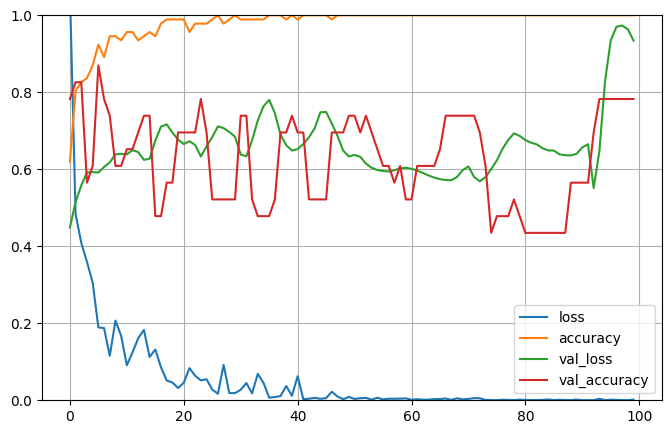

In [20]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [21]:
loss, accuracy = model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 458ms/step - loss: 0.3969 - accuracy: 0.8333


In [22]:
accuracy

0.8333333134651184

In [23]:
pred = model.predict(x_test)

1/1 [==============================] - 0s 119ms/step


In [24]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report

In [25]:
confusion_matrix(y_test, np.argmax(pred, axis=1))

array([[6, 2],
       [0, 4]], dtype=int64)

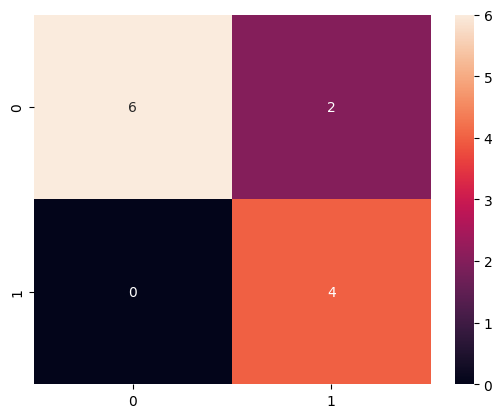

In [26]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, np.argmax(pred, axis=1)), annot=True);

In [27]:
print(classification_report(y_test, np.argmax(pred, axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



In [34]:
image=cv2.imread(str(df["img"][0]))
print(df["img"][0])
image.shape

plates/train/dirty/0017.jpg


(256, 341, 3)

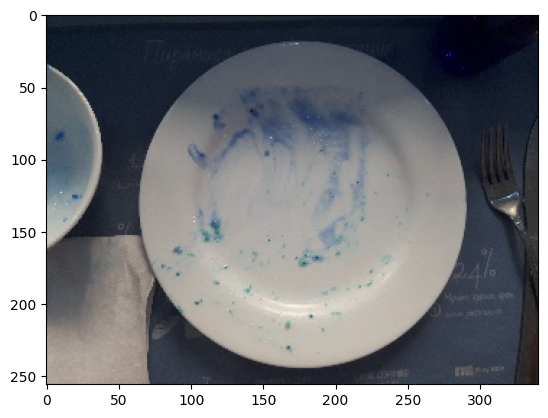

In [35]:
plt.imshow(image)

In [36]:
image=cv2.resize(image, (size,size))
image=image/255.0

In [37]:
image=np.array(image)

In [38]:
image=np.expand_dims(image, axis=0)

In [42]:
tahmin=model.predict(image)
labels[np.argmax(tahmin)]

1/1 [==============================] - 0s 30ms/step


'dirty'

In [44]:
dir="plates/test/test"
img_list=[]
for img_file in os.listdir(dir):
    img_list.append(dir+"/"+img_file)
test=pd.DataFrame({"img":img_list})
test.head()

,img
0,plates/test/test/0000.jpg
1,plates/test/test/0001.jpg
2,plates/test/test/0002.jpg
3,plates/test/test/0003.jpg
4,plates/test/test/0004.jpg


In [45]:
xt=[]
for image in test["img"]:
    try:
        img=cv2.imread(str(image))
        img=cv2.resize(img, (size,size))
        img=img/255.0 # Normalize etmek
        xt.append(img)
    except Exception as e:
        print(f"Hata: {e}")
        print(f"Hatalı resmin yolu: {image}")

In [46]:
xt=np.array(xt)

In [49]:
pred=model.predict(xt)
pred

24/24 [==============================] - 0s 11ms/step


array([[0.1794012 , 0.8205988 ],
       [0.08648   , 0.91352   ],
       [0.00759845, 0.9924016 ],
       ...,
       [0.34451413, 0.65548587],
       [0.01457921, 0.98542076],
       [0.92250884, 0.07749119]], dtype=float32)

In [65]:
test["label"]=[labels[np.argmax(row)] for row in pred]
test["id"] = test["img"].str.split("/").str[-1].str.split(".").str[0]
test.sample(10)

,img,class,label,id
714,plates/test/test/0714.jpg,cleaned,cleaned,0714
627,plates/test/test/0627.jpg,cleaned,cleaned,0627
580,plates/test/test/0580.jpg,cleaned,cleaned,0580
165,plates/test/test/0165.jpg,dirty,dirty,0165
720,plates/test/test/0720.jpg,cleaned,cleaned,0720
716,plates/test/test/0716.jpg,cleaned,cleaned,0716
203,plates/test/test/0203.jpg,dirty,dirty,0203
506,plates/test/test/0506.jpg,dirty,dirty,0506
85,plates/test/test/0085.jpg,cleaned,cleaned,0085
24,plates/test/test/0024.jpg,dirty,dirty,0024


In [66]:
test[["id", "label"]].to_csv("submission.csv", index=False)

## Sonuç

Kirli ve temiz tabak resimlerini sınıflandıran derin öğrenme modli Kaggle yarışmasında `0.88709` skor elde etmiştir.